In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import re
from pathlib import Path

from src.data.dataset import SliderDataset
from src.data.data_module import SliderDataModule
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchaudio

from itertools import groupby
from tqdm.auto import tqdm

In [16]:
stages = ["dev", "eval"]
for stage in stages:
    for split in ["train", "test"]:
        train_dir = Path(f"../data/raw/{stage}_data/{stage}_data/slider/{split}/")
        test_dir = Path(f"../data/raw/{stage}_data/{stage}_data/slider/{split}/")
        durations = []
        for file in tqdm(train_dir.iterdir()):
            info = torchaudio.info(file)
            durations.append(info.num_frames / info.sample_rate)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

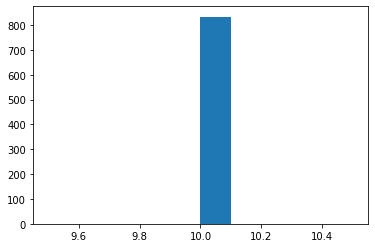

In [17]:
plt.hist(durations);

In [63]:
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    
def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

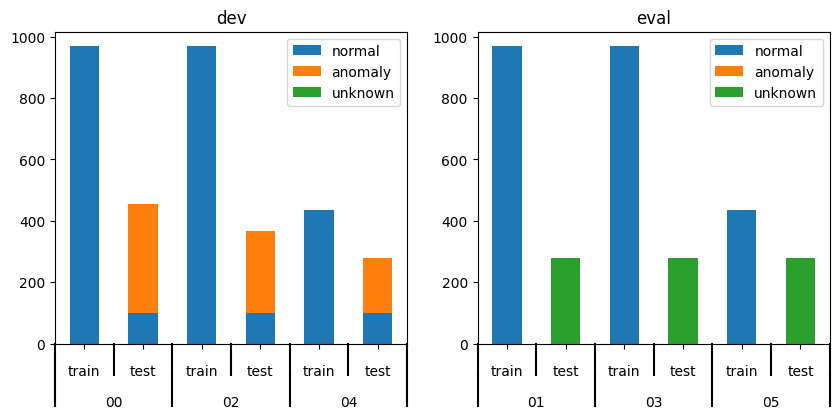

In [84]:
def get_metadata(p):
    prog = re.compile('(\w*)?_?id_(\d*)_(\d*)')
    regex_res = prog.match(p)
    return pd.Series((regex_res.group(1)[:-1],) + regex_res.group(2, 3), index=["label", "machine_id", "audio_id"])

fig = plt.figure(figsize=(10, 4), dpi=100)

stages = ["dev", "eval"]
for i, stage in enumerate(stages):
    train_dir = Path(f"../data/raw/{stage}_data/{stage}_data/slider/train/")
    test_dir = Path(f"../data/raw/{stage}_data/{stage}_data/slider/test/")
    df = pd.concat([
        pd.DataFrame({"subset": "train", "filename": [p.name for p in train_dir.iterdir()]}),
        pd.DataFrame({"subset": "test", "filename": [p.name for p in test_dir.iterdir()]})
    ])

    df = pd.concat([df, df["filename"].apply(get_metadata)], axis=1)
    df = pd.concat([
        df,
        df["label"].apply(lambda x: pd.Series([1 if x == "normal" else 0], index=['normal'])),
        df["label"].apply(lambda x: pd.Series([1 if x == "anomaly" else 0], index=['anomaly'])),
        df["label"].apply(lambda x: pd.Series([1 if x == "" else 0], index=['unknown']))
    ], axis=1)
    
    cols = ["machine_id", "subset"]
    group_df = df[cols + ["normal", "anomaly", "unknown"]].groupby(cols).sum()
    group_df = group_df.reindex(labels=["train", "test"], level='subset')
    
    ax = fig.add_subplot(120 + i + 1)
    group_df.plot(kind='bar',stacked=True, ax=fig.gca())
    #Below 3 lines remove default labels
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
    ax.set_title(stage)
    label_group_bar_table(ax, group_df)
    fig.subplots_adjust(bottom=.1*df.index.nlevels)
plt.show()

In [73]:
cols = ["machine_id", "subset"]
group_df = dev_df[cols + ["normal", "anomaly"]].groupby(cols).sum()
group_df = group_df.reindex(labels=["train", "test"], level='subset')

In [61]:
group_df

normal  anomaly
machine_id subset                 
00         train      968        0
           test       100      356
02         train      968        0
           test       100      267
04         train      434        0
           test       100      178

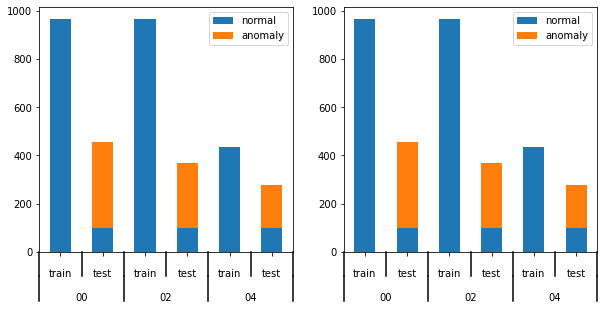

In [69]:
from itertools import groupby

df = group_df
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
df.plot(kind='bar',stacked=True,ax=fig.gca())
#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
label_group_bar_table(ax, df)
fig.subplots_adjust(bottom=.1*df.index.nlevels)

ax = fig.add_subplot(122)
df.plot(kind='bar',stacked=True,ax=fig.gca())
#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
label_group_bar_table(ax, df)
fig.subplots_adjust(bottom=.1*df.index.nlevels)

In [23]:
dm = SliderDataModule(
    data_dir="../data/raw",
    batch_size=128,
    num_workers=8,
    normalize=False,
    # maxlen=312,
    # use_cnn=True,
    iter_over_cols=False
)
dm.setup_subset("dev", "00")

In [24]:
test_ds = dm.active_subsets["test"]

In [36]:
normal_spec = test_ds[0]["input"].T
normal_spec.min()

tensor(-42.6426)

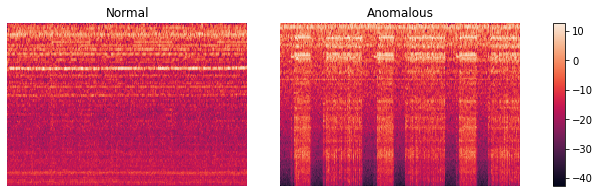

In [46]:
anomaly_spec = test_ds[0]["input"].T
normal_spec = test_ds[-10]["input"].T

vmin = min(normal_spec.min(), anomaly_spec.min())
vmax = max(normal_spec.max(), anomaly_spec.max())
fig, axs = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw=dict(width_ratios=[1, 1,0.05]))

sns.heatmap(normal_spec, ax=axs[0],xticklabels=False, yticklabels=False,cbar=False,vmin=vmin)
sns.heatmap(anomaly_spec, ax=axs[1],xticklabels=False, yticklabels=False,cbar=False,vmax=vmax)
axs[0].set_title("Normal")
axs[1].set_title("Anomalous")

fig.colorbar(axs[1].collections[0], cax=axs[2])

In [5]:
train_ds = dm.active_subsets["train"]
test_ds = dm.active_subsets["test"]
 
X_full = np.concatenate((train_ds.dataset.X, test_ds.X))
y_full = np.concatenate((train_ds.dataset.y, test_ds.y))

In [6]:
X_full.shape, y_full.shape

((445712, 128), (445712,))

In [7]:
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=50, batch_size=512)
X_ipca = ipca.fit_transform(X_full)
X_ipca.shape

(445712, 50)

In [8]:
# from  sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=8, verbose=10)

# tsne = TSNE(n_components=2, verbose=10)
X_tsne = tsne.fit_transform(X_ipca)

Performing t-SNE using 8 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 44571 of 445712
 - point 89142 of 445712
 - point 133713 of 445712
 - point 178284 of 445712
 - point 222855 of 445712
 - point 267426 of 445712
 - point 311997 of 445712
 - point 356568 of 445712
 - point 401139 of 445712
 - point 445710 of 445712
Done in 846.00 seconds (sparsity = 0.000326)!
Learning embedding...
Iteration 51: error is 140.214433 (50 iterations in 195.00 seconds)
Iteration 101: error is 140.697121 (50 iterations in 194.00 seconds)
Iteration 151: error is 140.701064 (50 iterations in 185.00 seconds)
Iteration 201: error is 140.499496 (50 iterations in 161.00 seconds)
Iteration 251: error is 139.246352 (50 iterations in 157.00 seconds)
Iteration 301: error is 8.283564 (50 iterations in 152.00 seconds)
Iteration 351: error is 7.719415 (50 iterations in 143.00 seconds)
Iteration 401: error is 7.386702 (50 iterations in 

In [10]:
X_tsne.shape

(445712, 2)

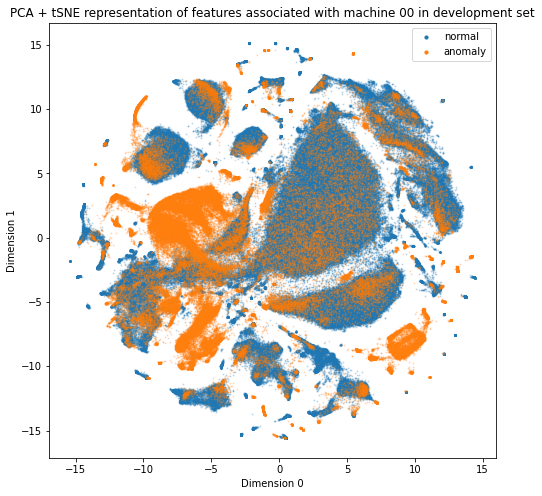

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_tsne[y_full == "normal", 0], X_tsne[y_full=="normal", 1], s=1, alpha=0.2, label="normal")
ax.scatter(X_tsne[y_full == "anomaly", 0], X_tsne[y_full== "anomaly", 1], s=1, alpha=0.2, label="anomaly")

ax.set_title("PCA + tSNE representation of features associated with machine 00 in development set")
ax.set_xlabel("Dimension 0")
ax.set_ylabel("Dimension 1")
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [10]
lgnd.legendHandles[0]._alpha = [1.0]
lgnd.legendHandles[1]._sizes = [10]
lgnd.legendHandles[1]._alpha = [1.0]